In [1]:
import importlib

import pandas as pd
from IPython.display import display

import warnings

warnings.filterwarnings('ignore')

#from carla.data.causal_model import CausalModel

In [2]:
import Semantic_Meaningfulness 
import carla
carla.data.causal_model=Semantic_Meaningfulness.carla_adaptions.causal_model

Using TensorFlow backend.


[INFO] Using Python-MIP package version 1.12.0 [model.py <module>]


In [3]:
import numpy as np 
import torch
import random

#SEED Setting
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

In [4]:
import pandas as pd
# generate data
scm = carla.data.causal_model.CausalModel("sanity-3-lin")
print(type(scm))
dataset = scm.generate_dataset(10000, False)

display(dataset.df)

<class 'Semantic_Meaningfulness.carla_adaptions.causal_model.CausalModel'>
3


,label,x1,x2,x3
0,1.0,-3.822251,3.206103,1.394095
1,0.0,-0.125186,-0.267489,-0.065593
2,0.0,1.388819,-2.420645,0.119093
3,0.0,-0.173873,-0.715379,-1.201855
4,1.0,-0.637307,1.071684,0.379442
...,...,...,...,...
9995,0.0,0.971876,-0.067054,-1.317657
9996,1.0,1.792395,-2.272653,0.620624
9997,0.0,1.994518,-3.212899,-0.900646
9998,0.0,-2.854051,3.213437,-0.361817


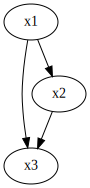

In [5]:
#Visualize the model
scm.cgm.draw()

In [6]:
from carla.models.catalog import MLModelCatalog

training_params = {"lr": 0.01, "epochs": 10, "batch_size": 16, "hidden_size": [18, 9, 3]}

ml_model = MLModelCatalog(
    dataset, model_type="ann", load_online=False, backend="pytorch"
)
ml_model.train(
    learning_rate=training_params["lr"],
    epochs=training_params["epochs"],
    batch_size=training_params["batch_size"],
    hidden_size=training_params["hidden_size"],
    force_train=True
)



balance on test set 0.5169333333333334, balance on test set 0.5152
Epoch 0/9
----------
train Loss: 0.0725 Acc: 0.9716

test Loss: 0.0608 Acc: 0.9776

Epoch 1/9
----------
train Loss: 0.0371 Acc: 0.9853

test Loss: 0.0255 Acc: 0.9888

Epoch 2/9
----------
train Loss: 0.0342 Acc: 0.9872

test Loss: 0.0268 Acc: 0.9868

Epoch 3/9
----------
train Loss: 0.0322 Acc: 0.9869

test Loss: 0.0276 Acc: 0.9884

Epoch 4/9
----------
train Loss: 0.0299 Acc: 0.9888

test Loss: 0.0201 Acc: 0.9912

Epoch 5/9
----------
train Loss: 0.0285 Acc: 0.9891

test Loss: 0.0188 Acc: 0.9920

Epoch 6/9
----------
train Loss: 0.0271 Acc: 0.9897

test Loss: 0.0162 Acc: 0.9928

Epoch 7/9
----------
train Loss: 0.0279 Acc: 0.9897

test Loss: 0.0192 Acc: 0.9928

Epoch 8/9
----------
train Loss: 0.0267 Acc: 0.9895

test Loss: 0.0474 Acc: 0.9816

Epoch 9/9
----------
train Loss: 0.0241 Acc: 0.9899

test Loss: 0.0591 Acc: 0.9756



In [7]:
from carla.models.negative_instances import predict_negative_instances
# get factuals
factuals = dataset.df#predict_negative_instances(ml_model, dataset.df)
test_factual_with_labels = factuals.iloc[:10].reset_index(drop=True)
test_factual=test_factual_with_labels.copy()
print(test_factual)

   label        x1        x2        x3
0    1.0 -3.822251  3.206103  1.394095
1    0.0 -0.125186 -0.267489 -0.065593
2    0.0  1.388819 -2.420645  0.119093
3    0.0 -0.173873 -0.715379 -1.201855
4    1.0 -0.637307  1.071684  0.379442
5    0.0 -2.087104  2.218720 -0.248939
6    0.0 -1.895168  2.386755 -0.718443
7    0.0  0.721627 -0.507613 -0.951930
8    0.0  1.772848 -1.068509 -0.722962
9    1.0  1.783160 -0.904946  1.107616


In [8]:
'''Causal Recourse Model '''
from carla.recourse_methods.catalog.causal_recourse import (
    CausalRecourse,
    constraints,
    samplers,
)
hyperparams = {
    "optimization_approach": "brute_force",
    "num_samples": 10,
    "scm": scm,
    "constraint_handle": constraints.point_constraint,
    "sampler_handle": samplers.sample_true_m0,
}

#print(len(test_factual))
# structural counterfactual (SCF)
#cfs = CausalRecourse(ml_model, hyperparams).get_counterfactuals(test_factual)
recourse=CausalRecourse(ml_model, hyperparams)

In [9]:
scm_output=carla.data.causal_model.CausalModel("sanity-3-lin-output")

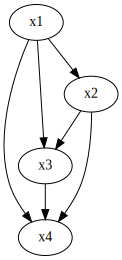

In [10]:
#Visualize the model
scm_output.cgm.draw()

In [11]:
import importlib
import Semantic_Meaningfulness.Semantic_Meaningfulness
from Semantic_Meaningfulness.Semantic_Meaningfulness import Semantic


In [12]:
'''Original Evaluation'''
from carla.data.catalog import CsvCatalog
from carla import Benchmark
mapping_dict={ 
      'u1': 'x1',
      'u2': 'x2',
    'u3': 'x3',
      }
# first initialize the benchmarking class by passing
# black-box-model, recourse method, and factuals into it
benchmark = Benchmark(ml_model, recourse, test_factual)

# now you can decide if you want to run all measurements
# or just specific ones.
evaluation_measures = [
    Semantic(ml_model, causal_graph_full=scm_output,causal_graph_small=scm),    
]

# now run all implemented measurements and create a
# DataFrame which consists of all results
results = benchmark.run_benchmark(evaluation_measures)

display(results.head(5))

,semantic,correct_relationships
0,1,1.0
1,1,1.0
2,1,1.0
3,0,1.0
4,1,1.0


In [13]:
# Averaging of the reults
mean= np.mean(results['semantic'])
std= np.std(results['semantic'])
print(f'Causal Recourse - Semantic results {mean} +/- {std}')

Causal Recourse - Semantic results 0.9 +/- 0.30000000000000004


In [14]:
# Averaging of the reults
mean= np.mean(results['correct_relationships'])
std= np.std(results['correct_relationships'])
print(f'Causal Recourse - Semantic relationships {mean} +/- {std}')

Causal Recourse - Semantic relationships 1.0 +/- 0.0
